In [34]:
import geopandas as gpd
import pandas as pd
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [35]:
# First get the country EEZs
url = "https://files.auspatious.com/unsw/EEZ_land_union_v4_202410.zip"
source_internal_path_name = "EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp"
zip_bytes = requests.get(url).content

with ZipMemoryFile(zip_bytes) as z:
    with z.open(source_internal_path_name) as src:
        eez = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [36]:
grids = gpd.read_file("twentyfifth_grids.geojson").to_crs("EPSG:4326")

print(len(grids),'total grids')

# bbox_png = gpd.read_file("bbox_png.geojson")

# Only select png grids
# grids_png = gpd.clip(grids, bbox_png)
condition = grids['GID_0'] == 'PNG'
grids_png = grids[condition]

print(len(grids_png), 'png grids')


27079 total grids
15058 png grids


In [39]:
# Only do png - quarter grids
quarter_grids = gpd.read_file("quarter_grids.geojson").to_crs("EPSG:4326")

print(len(quarter_grids),'total quarter grids')

# bbox_png = gpd.read_file("bbox_png.geojson")

# Only select png grids
# grids_png = gpd.clip(grids, bbox_png)
condition = quarter_grids['GID_0'] == 'PNG'
quarter_grids_png = quarter_grids[condition]

print(len(quarter_grids_png), 'png quarter grids')

quarter_grids_png = gpd.clip(quarter_grids_png, eez_png)
quarter_grids_png.to_file("quarter_grids_png.geojson")


1101 total quarter grids
645 png quarter grids


In [37]:
# Only do png
eez_png = eez[eez["ISO_SOV1"] == "PNG"].to_crs("EPSG:4326")

# Convert to ODC Geometry
eez_png_geom = Geometry(eez_png.geometry.values[0], crs=eez_png.crs)

eez_png_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries([eez_png_geom.geom]), # Use .geom to get the underlying shapely geometry
    crs=eez_png_geom.crs
)

# Now you can use GeoPandas functions:
# eez_png_gdf = gpd.clip(eez_png_gdf, bbox_png)


# eez_png.explore()

In [7]:
PACIFIC_EPSG

'EPSG:3832'

<Axes: >

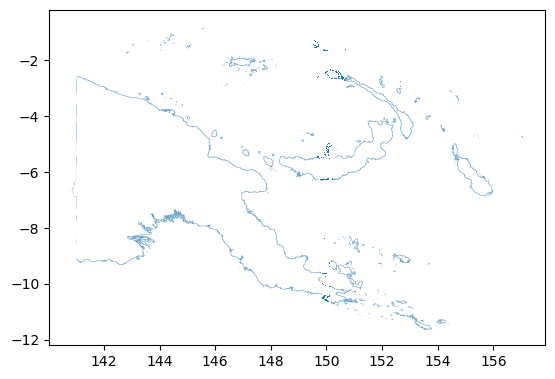

In [10]:
grids_png.plot()

In [9]:
grids_png = gpd.clip(grids_png, eez_png)
grids_png.to_file("grids_png.geojson")

In [13]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_seagrass"],
    # intersects=eez_png_geom.json
    intersects=eez_png_geom.json
).item_collection()

print(f"Found {len(items)} items")

data = load(
    items,
    bands=["seagrass"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)
data


Found 944 items


<xarray.Dataset> Size: 2GB
Dimensions:      (y: 12480, x: 22080, time: 8)
Coordinates:
  * y            (y) float64 100kB -6.405e+04 -6.415e+04 ... -1.312e+06
  * x            (x) float64 177kB -1.08e+06 -1.08e+06 ... 1.128e+06 1.128e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 2GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [11]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [14]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, eez_png_geom, variable="seagrass", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        "area_m2": area_m2,
        "area_km2": area_m2 / 1e6
    })

df = pd.DataFrame(results)
df

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


,time,area_m2,area_km2
0,2017,2.904540e+09,2904.54
1,2018,2.759730e+09,2759.73
2,2019,2.557360e+09,2557.36
3,2020,2.841650e+09,2841.65
4,2021,2.076160e+09,2076.16
5,2022,1.347340e+09,1347.34
6,2023,1.908950e+09,1908.95
7,2024,2.073700e+09,2073.70


/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<Axes: title={'center': 'PNG Seagrass Area Over Time'}, xlabel='time'>

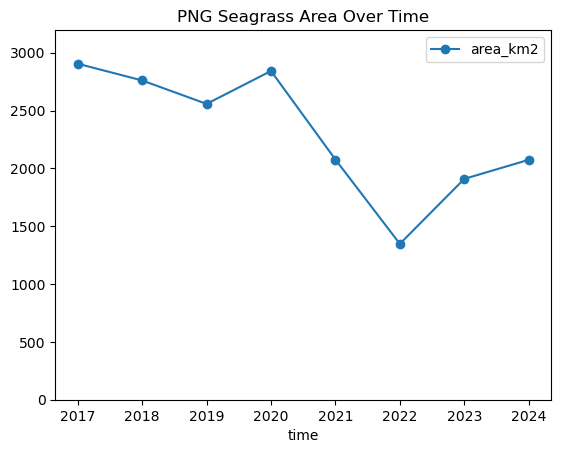

In [15]:
df.plot(x="time", y="area_km2", marker="o", title="PNG Seagrass Area Over Time", ylim=(0, df["area_km2"].max() * 1.1))

In [16]:
for r in results:
    print(f"{r['time']}: {r['area_km2']:.2f} km²")

2017: 2904.54 km²
2018: 2759.73 km²
2019: 2557.36 km²
2020: 2841.65 km²
2021: 2076.16 km²
2022: 1347.34 km²
2023: 1908.95 km²
2024: 2073.70 km²


In [17]:
data

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 12480, x: 22080, time: 8)
Coordinates:
  * y            (y) float64 100kB -6.405e+04 -6.415e+04 ... -1.312e+06
  * x            (x) float64 177kB -1.08e+06 -1.08e+06 ... 1.128e+06 1.128e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 2GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [18]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7) - data.seagrass.isel(time=1)

In [19]:
seagrass_2024 = data.seagrass.isel(time=7)
area_m2_seagrass_2024 =  xarray_calculate_area(seagrass_2024, eez_png_geom, variable="seagrass", value=1)
area_m2_seagrass_2024
area_km2_seagrass_2024 = area_m2_seagrass_2024/1000000
area_km2_seagrass_2024

2073.7

In [20]:
seagrass_2018 = data.seagrass.isel(time=1)
area_m2_seagrass_2018 =  xarray_calculate_area(seagrass_2018, eez_png_geom, variable="seagrass", value=1)
area_m2_seagrass_2018
area_km2_seagrass_2018 = area_m2_seagrass_2018/1000000
area_km2_seagrass_2018

2759.73

In [21]:
# from matplotlib import colors

# static_classes = [
#     [255, "No_data_1", "#850000", "maroon"],
#     [254, "No_data_2", "#eaed34", "yellow"],
#     [0, "No_seagrass", "#ffa200", "orange"],
#     [1, "Seagrass", "#4ffffa", "teal"],
#     [2, "Other", "#00000000", "transparent"]
# ]

# values_list = [c[0] for c in static_classes]
# static_color_list = [c[2] for c in static_classes]

# static_color_list = [cd[2] for cd in static_classes]
# bounds = values_list + [5]
# static_cmap = colors.ListedColormap(static_color_list)
# norm = colors.BoundaryNorm(bounds, cd_map.N)

In [22]:
# data.seagrass.isel(time=7).odc.explore(cmap = static_cmap)
data.seagrass.isel(time=7).odc.explore(cmap='viridis')

In [23]:
seagrass_change_2018_2024 = data.seagrass.isel(time=7)*-2 - data.seagrass.isel(time=1)

In [24]:
area_m2 = xarray_calculate_area(seagrass_change_2018_2024, eez_png_geom, variable="seagrass", value=1)

In [25]:
km2 = area_m2/1000000
km2

0.0

In [26]:
ha = km2*100
ha

0.0

In [27]:
seagrass_change_2018_2024

<xarray.DataArray 'seagrass' (y: 12480, x: 22080)> Size: 551MB
dask.array<sub, shape=(12480, 22080), dtype=int16, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 100kB -6.405e+04 -6.415e+04 ... -1.312e+06
  * x            (x) float64 177kB -1.08e+06 -1.08e+06 ... 1.128e+06 1.128e+06
    spatial_ref  int32 4B 3832

In [28]:
# from matplotlib import colors

# change_classes = [
#     [-765, "No_data_1", "#00000000", "transparent"],
#     [-511, "No_data_2", "#00000000", "transparent"],
#     [-510, "No_data_3", "#00000000", "transparent"],
#     [-257, "No_data_4", "#00000000", "transparent"],
#     [-255, "No_data_5", "#00000000", "transparent"],
#     [-3, "Increasing", "#4ffffa", "teal"],
#     [-2, "Decreasing", "#850000", "maroon"],
#     [-1, "Constant", "#eaed34", "yellow"]
# ]

# values_list = [c[0] for c in cd_classes]
# cd_color_list = [c[2] for c in cd_classes]

# cd_color_list = [cd[2] for cd in cd_classes]
# bounds = values_list + [8]
# cd_map = colors.ListedColormap(cd_color_list)
# norm = colors.BoundaryNorm(bounds, cd_map.N)

# seagrass_change_2018_2024.odc.explore(cmap =  cd_map)

In [29]:
# seagrass_change_2018_2024.plot(cmap=static_map)

In [30]:
# seagrass_change_2018_2024.odc.explore()

In [31]:
seagrass_change_2018_2024.odc.write_cog("seagrass_change_2018_2024_png.tiff", overwrite=True)

PosixPath('seagrass_change_2018_2024_png.tiff')

In [32]:
seagrass_2018.odc.write_cog("seagrass_2018_png.tiff")

PosixPath('seagrass_2018_png.tiff')

In [33]:
seagrass_2024.odc.write_cog("seagrass_2024_png.tiff")

PosixPath('seagrass_2024_png.tiff')